In [195]:
# File Imports
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import tree

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.svm import SVC 
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


# Needed for decision tree visualization
import pydotplus 
from IPython.display import Image

# Suppress Warnings
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings("ignore", category=DataConversionWarning)

# Prepare the Data

In [196]:
# Import the data:
file_location = "./resources/data_science_salaries.csv"
file_path = Path(file_location)

salary_df = pd.read_csv(file_path)
# Display the DataFrame:
salary_df.head()

,job_title,experience_level,employment_type,work_models,work_year,employee_residence,salary,salary_currency,salary_in_usd,company_location,company_size
0,Data Engineer,Mid-level,Full-time,Remote,2024,United States,148100,USD,148100,United States,Medium
1,Data Engineer,Mid-level,Full-time,Remote,2024,United States,98700,USD,98700,United States,Medium
2,Data Scientist,Senior-level,Full-time,Remote,2024,United States,140032,USD,140032,United States,Medium
3,Data Scientist,Senior-level,Full-time,Remote,2024,United States,100022,USD,100022,United States,Medium
4,BI Developer,Mid-level,Full-time,On-site,2024,United States,120000,USD,120000,United States,Medium


<module 'matplotlib.pyplot' from '/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/matplotlib/pyplot.py'>

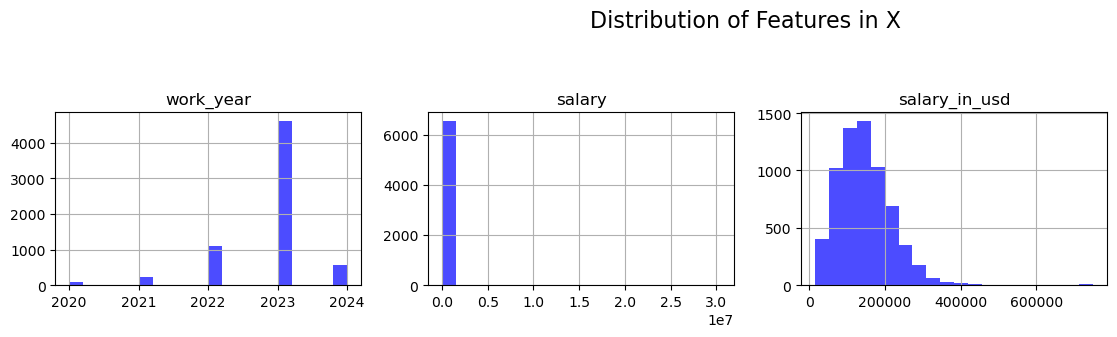

In [197]:
# Graph Feature Dat:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms for each feature in X
X = salary_df.select_dtypes(include=['float64', 'int64'])  # Select numerical features
X.hist(bins=20, figsize=(15, 10), layout=(4, 4), color='blue', alpha=0.7)
plt.suptitle('Distribution of Features in X', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt

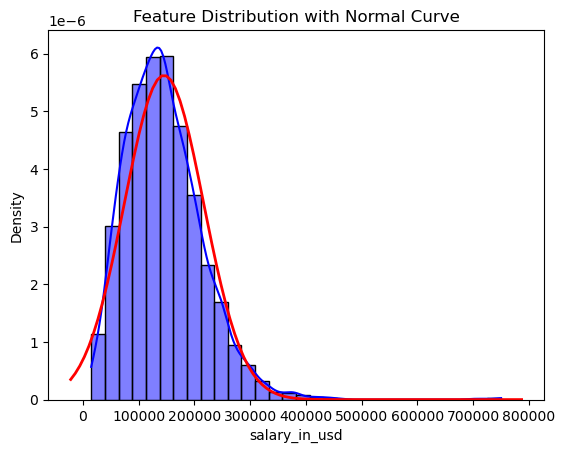

In [198]:
# Choose a specific column from X or y
feature_to_plot = X.iloc[:, 2]  # Replace with specific feature column if needed

# Plot the histogram with KDE
sns.histplot(feature_to_plot, kde=True, stat="density", color="blue", bins=30)
# Overlay a normal distribution
mean, std = feature_to_plot.mean(), feature_to_plot.std()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)
plt.plot(x, p, 'r', linewidth=2)
plt.title('Feature Distribution with Normal Curve')
plt.show()

In [199]:
# Data Partitioning: Attempt 1 of 2: Calculate the average range based on the 68% of the Empirical rule
mean_salary = np.mean(feature_to_plot)
std_salary = np.std(feature_to_plot)

lower_bound = mean_salary - std_salary
upper_bound = mean_salary + std_salary

print(f"68% range: ({lower_bound}, {upper_bound})")

68% range: (74619.09627855755, 216502.0208604029)


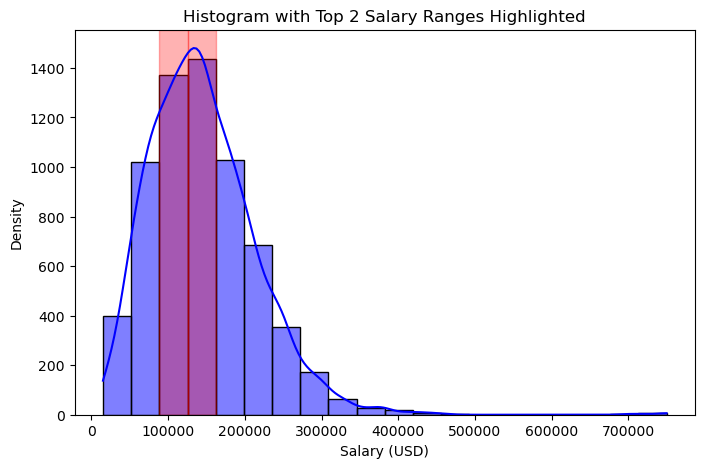

Top 2 most frequent salary ranges: [(88500.0, 125250.0), (125250.0, 162000.0)]


In [200]:
# Data Partitionaing: Attempt 2 of 2: Using the two highest bars as the average
counts, bin_edges = np.histogram(feature_to_plot, bins=20)  # Adjust bins as needed

# Find indices of the two highest bins
top_2_indices = np.argsort(counts)[-2:]  # Get the two highest bins

# Get the corresponding salary ranges
top_2_ranges = [(bin_edges[i], bin_edges[i+1]) for i in top_2_indices]

# Plot the histogram
plt.figure(figsize=(8, 5))
sns.histplot(feature_to_plot, bins=20, kde=True, color="blue", alpha=0.5)

# Highlight the two highest bars
for low, high in top_2_ranges:
    plt.axvspan(low, high, color="red", alpha=0.3)  # Highlight range

plt.xlabel("Salary (USD)")
plt.ylabel("Density")
plt.title("Histogram with Top 2 Salary Ranges Highlighted")
plt.show()

# Print the identified ranges
print(f"Top 2 most frequent salary ranges: {top_2_ranges}")

In [ ]:
# Binning Employee Salary (y):

# Visual observation of the range of the Highest two bars
bins = [1500, 50000, 156000, 176000, 750000]

# Statical calculation of the range for the Highest two bars
# bins = [1500, 50000, 8500, 162000, 750000]


# PDCUT: Binning
# salary_df["Employee Salary"], bin_edges = pd.qcut(salary_df["salary_in_usd"], q=4, labels=False, retbins=True)

# Create labels for these bins
group_names = ["Very Low", "Low", "Average", "High"]

salary_data = X["salary_in_usd"]
# Slice the data and place it into bins
binned_data = pd.cut(salary_data, bins, labels=group_names, include_lowest=True)
display(binned_data)
salary_binned = pd.DataFrame()

# Place the data series into Employee Salary DataFrame
salary_binned["Employee Salary"] = binned_data

0            Low
1            Low
2            Low
3            Low
4            Low
          ...   
6594    Very Low
6595    Very Low
6596         Low
6597         Low
6598         Low
Name: salary_in_usd, Length: 6599, dtype: category
Categories (4, object): ['Very Low' < 'Low' < 'Average' < 'High']

In [202]:
# Create DataFrame with binned categories and original salaries
salary_and_bin = pd.DataFrame({"Employee Salary": salary_data, "Salary Bin": binned_data})


# Compute count and mean for each bin
salary_stats = salary_and_bin.groupby("Salary Bin", observed=False)["Employee Salary"].agg(['count', 'mean'])
# Rename columns for clarity
salary_stats.columns = ["Employee Count", "Average Salary"]

# Display as a table
print(salary_stats)

            Employee Count  Average Salary
Salary Bin                                
Very Low               494    41010.093117
Low                   3357   107939.917188
Average                835   163510.844311
High                  1913   230741.914794


In [203]:
# Load X dataset:
# Drop collinear data:
X = salary_df.copy()
X = X.drop(columns=["salary", "salary_currency", "salary_in_usd", "work_year"], axis=1)

display("Info:", X.info())
display("Salary:", X.head())
display("value_counts:", X["work_models"].value_counts())

# Get Nominal Column Names Only
nominal_features = X.select_dtypes(include="object").columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6599 entries, 0 to 6598
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   job_title           6599 non-null   object
 1   experience_level    6599 non-null   object
 2   employment_type     6599 non-null   object
 3   work_models         6599 non-null   object
 4   employee_residence  6599 non-null   object
 5   company_location    6599 non-null   object
 6   company_size        6599 non-null   object
dtypes: object(7)
memory usage: 361.0+ KB


'Info:'

None

'Salary:'

,job_title,experience_level,employment_type,work_models,employee_residence,company_location,company_size
0,Data Engineer,Mid-level,Full-time,Remote,United States,United States,Medium
1,Data Engineer,Mid-level,Full-time,Remote,United States,United States,Medium
2,Data Scientist,Senior-level,Full-time,Remote,United States,United States,Medium
3,Data Scientist,Senior-level,Full-time,Remote,United States,United States,Medium
4,BI Developer,Mid-level,Full-time,On-site,United States,United States,Medium


'value_counts:'

work_models
On-site    3813
Remote     2561
Hybrid      225
Name: count, dtype: int64

In [204]:
# Load Y dataset:
# y = binned_data
y = binned_data
display("X shape:", X.shape[0])
display("y", y)
display("y", y.info())
display("Y shape:", y.shape)
display(y.describe())

'X shape:'

6599

'y'

0            Low
1            Low
2            Low
3            Low
4            Low
          ...   
6594    Very Low
6595    Very Low
6596         Low
6597         Low
6598         Low
Name: salary_in_usd, Length: 6599, dtype: category
Categories (4, object): ['Very Low' < 'Low' < 'Average' < 'High']

<class 'pandas.core.series.Series'>
RangeIndex: 6599 entries, 0 to 6598
Series name: salary_in_usd
Non-Null Count  Dtype   
--------------  -----   
6599 non-null   category
dtypes: category(1)
memory usage: 6.8 KB


'y'

None

'Y shape:'

(6599,)

count     6599
unique       4
top        Low
freq      3357
Name: salary_in_usd, dtype: object

In [205]:
# Preprocessing: Convert Nominal to Ordinal Data with Get Dummies:

X_encoded = pd.get_dummies(X, columns=nominal_features, drop_first=True, dtype=int)
# y_encoded = pd.get_dummies(y, drop_first=True, dtype=int)
le = LabelEncoder()
# One column only (reshape)
y_encoded = le.fit_transform(y)
y_encoded_1_dim = y_encoded
# print("y_encoded:", y_encoded.tolist())
# display("y_encoded:", y_encoded)

y_encoded = y_encoded.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, random_state=1)

display("xTrain:", X_train)
display("yTrain:", y_train)

'xTrain:'

,job_title_AI Developer,job_title_AI Engineer,job_title_AI Product Manager,job_title_AI Programmer,job_title_AI Research Engineer,job_title_AI Scientist,job_title_AWS Data Architect,job_title_Analytics Engineer,job_title_Analytics Engineering Manager,job_title_Applied Data Scientist,...,company_location_Switzerland,company_location_Thailand,company_location_Turkey,company_location_Ukraine,company_location_United Arab Emirates,company_location_United Kingdom,company_location_United States,company_location_Vietnam,company_size_Medium,company_size_Small
477,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1989,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
711,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3234,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2857,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
5192,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3980,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
235,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


'yTrain:'

array([[1],
       [1],
       [2],
       ...,
       [0],
       [1],
       [1]])

In [206]:
# Baseline Pipelineg Model Fitting:
# pipe = Pipeline([("Scale", StandardScaler()), ("LR", LinearRegression())])
# KNeighborsClassifier(n_neighbors=5)

models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVC": SVC(kernel='linear'),
    "DTC": DecisionTreeClassifier(max_depth=5),
    "RFC": RandomForestClassifier(),
    "ABC": AdaBoostClassifier()
}

for name, model in models.items():
    # Use odd n_neighbors for tie breakers
    pipe = Pipeline([("Scale", StandardScaler()), (name, model)])
                                                
    # Q3: Why am I getting an error here?
    pipe.fit(X_train, y_train)

    # Pass in text
    y_pred = pipe.predict(X_test)
    
    print(f'Score: {name}; {pipe.score(X_test, y_test)}')

Score: KNN; 0.5145454545454545
Score: SVC; 0.58
Score: DTC; 0.566060606060606
Score: RFC; 0.583030303030303


/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Score: ABC; 0.593939393939394


In [207]:
# Optimization:
# from sklearn.model_selection import RandomizedSearchCV


untuned_model = KNeighborsClassifier()
grid_tuned_model = KNeighborsClassifier()
random_tuned_model = KNeighborsClassifier()



In [208]:
# OP Part1: Untuned Model
untuned_model = KNeighborsClassifier()
untuned_model.fit(X_train, y_train)
# predicted
predictions_untuned = untuned_model.predict(X_test)
target_names = ["0", "1", "2", "3"]
print(classification_report(y_test, predictions_untuned, target_names=target_names))

              precision    recall  f1-score   support

           0       0.17      0.18      0.17       207
           1       0.46      0.60      0.53       448
           2       0.66      0.59      0.62       873
           3       0.72      0.39      0.51       122

    accuracy                           0.53      1650
   macro avg       0.50      0.44      0.46      1650
weighted avg       0.55      0.53      0.53      1650



In [209]:
# # NOT STOPPING: 
# # OP Part2: Create the GridSearchCV estimator 
# # Include both uniform and distance options for weights.
# from sklearn.model_selection import GridSearchCV
# # hypertune params
# # every other because it takes a long time, could do all

# # create dictionary with parameters
# grid_parameters = {
#     "n_neighbors": np.arange(11, 21, 2),
#     "leaf_size": np.arange(1, 501),
#     "weights": ["uniform", "distance"]
# }

# # Create the instance of GridSearch CV model, with parameters
# grid_model = GridSearchCV(grid_tuned_model, grid_parameters, verbose=3)

# # Fit the model by using the grid search estimator.
# grid_model.fit(X_train, y_train)
# # List the best parameters for this dataset
# # what is the best leafsize, and params
# print(grid_model.best_params_)

In [210]:
# OP: Part 3: Create the Baseline RandomizedSearchCV estimator

random_parameters = {
    "n_neighbors": np.arange(5, 21, 2),
    "leaf_size": np.arange(1, 501),
    "weights": ["uniform", "distance"]
}

random_model = RandomizedSearchCV(random_tuned_model, random_parameters, verbose=3)

random_model.fit(X_train, y_train)

target_names = ["0", "1", "2", "3"]

# List the best parameters for this dataset
print("BEST FIT:", random_model.best_params_)

# Make predictions with the hypertuned model
predications_random = random_model.predict(X_test)
print(classification_report(y_test, predications_random,target_names=target_names))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END leaf_size=452, n_neighbors=9, weights=distance;, score=0.464 total time=   0.1s
[CV 2/5] END leaf_size=452, n_neighbors=9, weights=distance;, score=0.518 total time=   0.1s
[CV 3/5] END leaf_size=452, n_neighbors=9, weights=distance;, score=0.539 total time=   0.1s
[CV 4/5] END leaf_size=452, n_neighbors=9, weights=distance;, score=0.522 total time=   0.1s
[CV 5/5] END leaf_size=452, n_neighbors=9, weights=distance;, score=0.540 total time=   0.1s
[CV 1/5] END leaf_size=405, n_neighbors=11, weights=distance;, score=0.500 total time=   0.1s
[CV 2/5] END leaf_size=405, n_neighbors=11, weights=distance;, score=0.520 total time=   0.1s
[CV 3/5] END leaf_size=405, n_neighbors=11, weights=distance;, score=0.533 total time=   0.1s
[CV 4/5] END leaf_size=405, n_neighbors=11, weights=distance;, score=0.528 total time=   0.1s
[CV 5/5] END leaf_size=405, n_neighbors=11, weights=distance;, score=0.543 total time=   0.1s
[CV 

In [211]:
# Op Part 4: Scale Split data and find Best KNN value:
X_scaler = StandardScaler()
X_scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

k: 5, Train Score: 0.551 | Test Score: 0.515
k: 7, Train Score: 0.575 | Test Score: 0.548
k: 9, Train Score: 0.574 | Test Score: 0.554
k: 11, Train Score: 0.565 | Test Score: 0.555
k: 13, Train Score: 0.571 | Test Score: 0.565
k: 15, Train Score: 0.574 | Test Score: 0.570
k: 17, Train Score: 0.574 | Test Score: 0.568
k: 19, Train Score: 0.569 | Test Score: 0.562
k: 21, Train Score: 0.569 | Test Score: 0.561
k: 23, Train Score: 0.569 | Test Score: 0.566


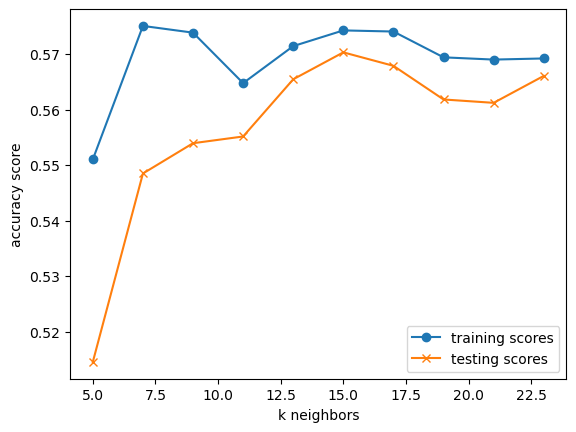

In [212]:

# Find Best K value
train_scores = []
test_scores = []

for k in range(5, 25, 2):
    # Use KNN Classifer Model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    
    # Score for training
    train_score = knn.score(X_train_scaled, y_train)
    
    # Score for the test
    test_score = knn.score(X_test_scaled, y_test)
    
    # add the caculated scores to the list we just calculated
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train Score: {train_score:.3f} | Test Score: {test_score:.3f}")
    
# PyPlot Library: Plot the results
# Plot training scores, we need the saved k range for x axis on plot
# Optimal score would be 9, because that is where the testing scores are
# better than our training data.  The first whole number after the testing 
# and training data cross
plt.plot(range(5, 25, 2), train_scores, marker='o', label="training scores")
plt.plot(range(5, 25, 2), test_scores, marker="x", label="testing scores")
plt.xlabel("k neighbors")
plt.ylabel("accuracy score")
plt.legend()
plt.show()

In [213]:
# Plot KNN with best value:
knn = KNeighborsClassifier(n_neighbors=21)
knn.fit(X_train_scaled, y_train)
print('k=21 Test Acc: %.3f' % knn.score(X_test_scaled, y_test))

k=21 Test Acc: 0.561


In [214]:
# Optimization Part 5: RandomOverSampling RandomUnderSampling
# #Deterimine if  y_encoded is unbalaced:  
# Results indicate uneven distribution, between class 3 (least) and 2 (most)
# Recommendation: OverSampling


print("y_encoded:", pd.Series(y_encoded_1_dim).value_counts())
'''
Class 2 has 3651 samples (dominant class).
Class 1 has 1913 samples.
Class 0 has 652 samples.
Class 3 has 383 samples (least frequent).
'''

y_encoded: 2    3357
1    1913
0     835
3     494
Name: count, dtype: int64


'\nClass 2 has 3651 samples (dominant class).\nClass 1 has 1913 samples.\nClass 0 has 652 samples.\nClass 3 has 383 samples (least frequent).\n'

In [215]:
# Apply Random Over Sampling
over_sampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = over_sampler.fit_resample(X_train, y_train)

# Check new distribution
print(pd.Series(y_train_resampled).value_counts())

1    2484
2    2484
3    2484
0    2484
Name: count, dtype: int64


In [216]:
# Rerun Models with OverSampled data:
# Results Worse
models = {
    "KNN": KNeighborsClassifier(n_neighbors=21),
    "SVC": SVC(kernel='linear'),
    "DTC": DecisionTreeClassifier(),
    "RFC": RandomForestClassifier(),
    "ABC": AdaBoostClassifier()
}

# Run models on the resampled training data
for name, model in models.items():
    # Create the pipeline
    pipe = Pipeline([("Scale", StandardScaler()), (name, model)])

    # Fit the pipeline on the resampled training data
    pipe.fit(X_train_resampled, y_train_resampled)

    # Make predictions on the test set
    y_pred = pipe.predict(X_test)

    print(f'Score: {name}; {pipe.score(X_test, y_test)}')

Score: KNN; 0.5048484848484849
Score: SVC; 0.3781818181818182
Score: DTC; 0.46606060606060606
Score: RFC; 0.47333333333333333


/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Score: ABC; 0.45575757575757575


In [217]:
# RandomUnderSampling:
# Apply Random Under Sampling
under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=1)
X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train, y_train)

# Check new distribution
print(pd.Series(y_train_resampled).value_counts())

0    372
1    372
2    372
3    372
Name: count, dtype: int64


In [218]:
# Rerun Models with UnderSampled data:
# Results Worse
models = {
    "KNN": KNeighborsClassifier(n_neighbors=21),
    "SVC": SVC(kernel='linear'),
    "DTC": DecisionTreeClassifier(),
    "RFC": RandomForestClassifier(),
    "ABC": AdaBoostClassifier()
    
}

# Run models on the resampled training data
for name, model in models.items():
    # Create the pipeline
    pipe = Pipeline([("Scale", StandardScaler()), (name, model)])

    # Fit the pipeline on the resampled training data
    pipe.fit(X_train_resampled, y_train_resampled)

    # Make predictions on the test set
    y_pred = pipe.predict(X_test)

    print(f'Score: {name}; {pipe.score(X_test, y_test)}')
    # Mean Squared Error
    # mse = mean_squared_error(y_test, y_pred)
    # print(f'{name}, mse: {mse}')

    # # R-squared Score
    # r2 = r2_score(y_test, y_pred)
    # print(f'{name}, R2: {r2}')

    # # Adjusted R-squared
    # r2_a = r2_adj(X_test, y_test, pipe)
    # print(f'{name}, r2_adj: {r2_a}')

Score: KNN; 0.25272727272727274
Score: SVC; 0.3624242424242424
Score: DTC; 0.3987878787878788
Score: RFC; 0.4036363636363636
Score: ABC; 0.43333333333333335


/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [219]:
# SMOTEENN Sampling:
# Apply Random Under Sampling
smt_sampler = SMOTEENN(sampling_strategy='auto', random_state=1)
X_train_resampled, y_train_resampled = smt_sampler.fit_resample(X_train, y_train)

# Check new distribution
print(pd.Series(y_train_resampled).value_counts())

3    1807
1     531
2     315
0     174
Name: count, dtype: int64


In [220]:
# Rerun Models with SMOTEEN Resampled data:
# Results Worse
models = {
    "KNN": KNeighborsClassifier(n_neighbors=21),
    "SVC": SVC(kernel='linear'),
    "DTC": DecisionTreeClassifier(),
    "RFC": RandomForestClassifier(),
    "ABC": AdaBoostClassifier()
}

# Run models on the resampled training data
for name, model in models.items():
    # Create the pipeline
    pipe = Pipeline([("Scale", StandardScaler()), (name, model)])

    # Fit the pipeline on the resampled training data
    pipe.fit(X_train_resampled, y_train_resampled)

    # Make predictions on the test set
    y_pred = pipe.predict(X_test)

    print(f'Score: {name}; {pipe.score(X_test, y_test)}')
    # Mean Squared Error
    # mse = mean_squared_error(y_test, y_pred)
    # print(f'{name}, mse: {mse}')

    # # R-squared Score
    # r2 = r2_score(y_test, y_pred)
    # print(f'{name}, R2: {r2}')

    # # Adjusted R-squared
    # r2_a = r2_adj(X_test, y_test, pipe)
    # print(f'{name}, r2_adj: {r2_a}')

Score: KNN; 0.32242424242424245
Score: SVC; 0.43636363636363634
Score: DTC; 0.3660606060606061
Score: RFC; 0.36848484848484847


/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Score: ABC; 0.48363636363636364
